![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

# Deep Multivariable Neural Network

In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import sys
import datetime
import re
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#pip install --upgrade keras
#pip install --upgrade tensorflow

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredLogarithmicError, CosineSimilarity
from keras import metrics

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
hello = tf.constant('Hello, TensorFlow!')

print(hello)

tf.Tensor(b'Hello, TensorFlow!', shape=(), dtype=string)


We will implement mlflow for training a multivariable deep neural network

### Loading and Cleaning the Data

In [3]:
# Load the training and test sets.

# We will not use this for the models. Uploading this only for comparision reasons. 

X_train = pd.read_csv('../Data/X_train.csv')
y_train = pd.read_csv('../Data/y_train.csv')
X_test = pd.read_csv('../Data/X_test.csv')
y_test = pd.read_csv('../Data/y_test.csv')

for dataset in [X_train, y_train, X_test, y_test]:
    print(dataset.shape)

X_train = X_train.drop(X_train.columns[0], axis=1)
y_train = y_train.drop(y_train.columns[0], axis=1)
X_test = X_test.drop(X_test.columns[0], axis=1)
y_test = y_test.drop(y_test.columns[0], axis=1)

for dataset in [X_train, y_train, X_test, y_test]:
    print(dataset.shape)
    
X_train

(1951, 29)
(1951, 2)
(488, 29)
(488, 2)
(1951, 28)
(1951, 1)
(488, 28)
(488, 1)


,comments,duration,languages,num_speaker,film_month,pub_month,film_weekday,pub_weekday,Funny,Beautiful,...,Jaw-dropping,OK,Obnoxious,Inspiring,positive,negative,pop_ratio,Popular,event_cat_TED,event_cat_TEDx
0,46,956,22,1,4,9,5,3,18,20,...,29,72,238,72,791,754,1.049072,0,0,1
1,25,686,23,1,6,7,5,1,52,319,...,47,5,4,282,1027,11,93.363636,1,1,0
2,40,276,28,1,12,4,2,2,11,123,...,22,31,13,71,312,44,7.090909,1,1,0
3,53,518,24,1,2,2,4,3,202,14,...,79,50,7,24,829,53,15.641509,1,1,0
4,103,878,26,1,2,6,1,3,16,109,...,33,40,1,86,772,30,25.733333,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,104,470,37,1,7,11,2,1,393,245,...,85,48,5,248,1956,33,59.272727,1,1,0
1947,82,703,33,1,6,8,0,1,0,56,...,28,39,2,247,656,17,38.588235,1,0,1
1948,177,239,41,1,2,4,6,4,112,178,...,76,210,209,157,1048,716,1.463687,0,1,0
1949,174,1152,20,1,2,6,4,0,2,256,...,153,51,43,448,1955,238,8.214286,1,1,0


In [4]:
X_train.columns[0]

'comments'

In [5]:
X_test.columns

Index(['comments', 'duration', 'languages', 'num_speaker', 'film_month',
       'pub_month', 'film_weekday', 'pub_weekday', 'Funny', 'Beautiful',
       'Ingenious', 'Courageous', 'Longwinded', 'Confusing', 'Informative',
       'Fascinating', 'Unconvincing', 'Persuasive', 'Jaw-dropping', 'OK',
       'Obnoxious', 'Inspiring', 'positive', 'negative', 'pop_ratio',
       'Popular', 'event_cat_TED', 'event_cat_TEDx'],
      dtype='object')

In [6]:
y_test

,views
0,4376218
1,727807
2,602203
3,1407692
4,620073
...,...
483,736224
484,1101811
485,1419314
486,679711


As mentioned these datasets were only upload so we can compare them later with the actual final dataset we will create below. 

We need to create dummy variables for the variables that should be categorical variables such as film_month, pub_month, etc. and the other categorical variables in the original dataset, such as speaker_occupation, should also be included in the data before analysis is done. 

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Creating the actual cleaned dataset
## Reading in the 'ted' talk data.

In [85]:

ted = pd.read_csv('../Data/ted_main.csv')

In [86]:
# Categorize events into TED and TEDx; exclude those that are non-TED events
ted = ted[ted['event'].str[0:3]=='TED'].reset_index()

In [87]:
ted.loc[:,'event_cat'] = ted['event'].apply(lambda x: 'TEDx' if x[0:4]=='TEDx' else 'TED')
print ("No. of talks remain: ", len(ted))

No. of talks remain:  2439


Here, we change the Unix timstamp to human readable date format. Then we extract month and day of week from film date and published date.

In [88]:

ted['film_date'] = ted['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['published_date'] = ted['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
ted['film_month'] = ted['film_date'].apply(lambda x: x.month)
ted['pub_month'] = ted['published_date'].apply(lambda x: x.month)
ted['film_year'] = ted['film_date'].apply(lambda x: x.year)
ted['pub_year'] = ted['published_date'].apply(lambda x: x.year)
ted['film_weekday'] = ted['film_date'].apply(lambda x: x.weekday()) # Monday: 0, Sunday: 6
ted['pub_weekday'] = ted['published_date'].apply(lambda x: x.weekday())
ted[['film_date','published_date']].head()

,film_date,published_date
0,2006-02-24,2006-06-26
1,2006-02-24,2006-06-26
2,2006-02-23,2006-06-26
3,2006-02-25,2006-06-26
4,2006-02-21,2006-06-27


TED users can give ratings to each talk. There are 14 possible ratings and they will be categorized as positive, negative and neutral:

Positive: 'Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive' Negative: 'Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing' Neutral: 'OK'

Here, we define a "popular" TED talk by its ratio of positive to negative ratings (which we call it "popularity ratio" here). If the popularity ratio is above 5, it is defined as "Popular", otherwise it is "Not Popular". Transformation is made to avoid "divided by zero" error. The following code is adopted from this kernel to convert 'ratings' column (a JSON object) into columns of each rating

In [89]:

ted['ratings']=ted['ratings'].str.replace("'",'"')
ted=ted.merge(ted.ratings.apply(lambda x: pd.Series(pd.read_json(x)['count'].values,index=pd.read_json(x)['name'])), 
            left_index=True, right_index=True)

In [90]:
Positive = ['Beautiful', 'Courageous', 'Fascinating', 'Funny', 'Informative', 'Ingenious', 'Inspiring', 'Jaw-dropping', 'Persuasive']
Negative = ['Confusing', 'Longwinded', 'Obnoxious', 'Unconvincing']
ted['positive']=ted.loc[:,Positive].sum(axis=1)+1
ted['negative']=ted.loc[:,Negative].sum(axis=1)+1
ted['pop_ratio']=ted['positive']/ted['negative']
ted.loc[:,'Popular'] = ted['pop_ratio'].apply (lambda x: 1 if x >5 else 0)

print ("No. of Not Popular talks: ", len(ted[ted['Popular']==0]))
# print ("Ratio of Popular talks: {:.4f}".format(len(ted[ted['Popular']==1])/ float(len(ted))))
overall_mean_popular = np.mean(ted.Popular)
print ("Ratio of Popular talks: {:.4f}".format(overall_mean_popular))

No. of Not Popular talks:  301
Ratio of Popular talks: 0.8766


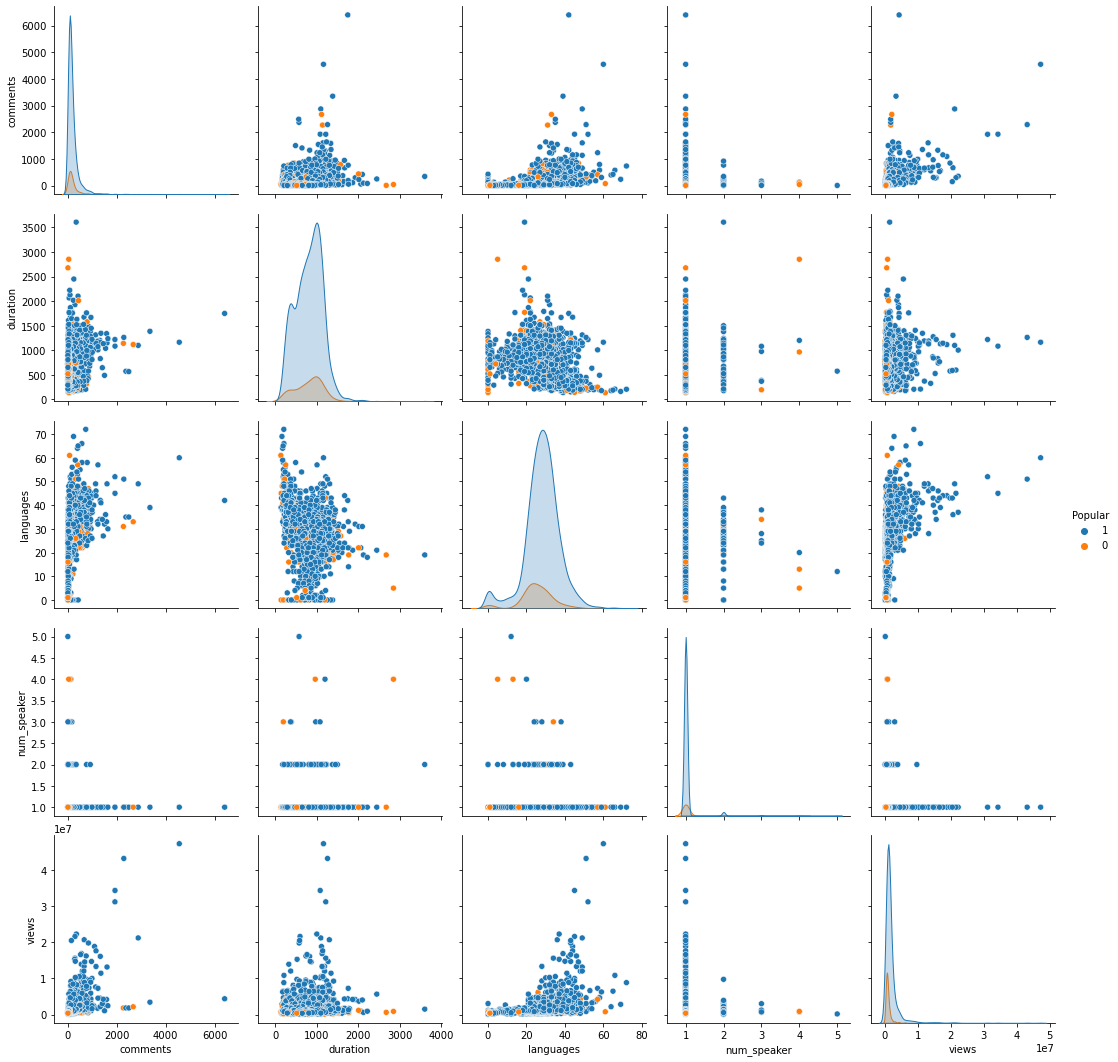

In [91]:
nums = ['comments', 'duration', 'languages', 'num_speaker', 'views']
sns.pairplot(ted, vars=nums, hue='Popular', hue_order = [1,0], diag_kind='kde', height=3);

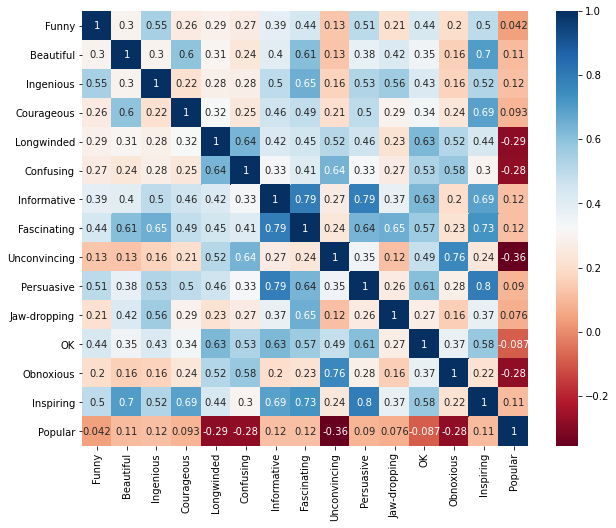

In [92]:
ratings = ['Funny', 'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing', 'Informative', 'Fascinating', 'Unconvincing', 
           'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring', 'Popular']
plt.figure(figsize=(10,8))
sns.heatmap(ted[ratings].corr(), annot=True, cmap='RdBu');

Then we do count vectorizer on 'speaker_occupation'. Before that, some data cleaning is needed.

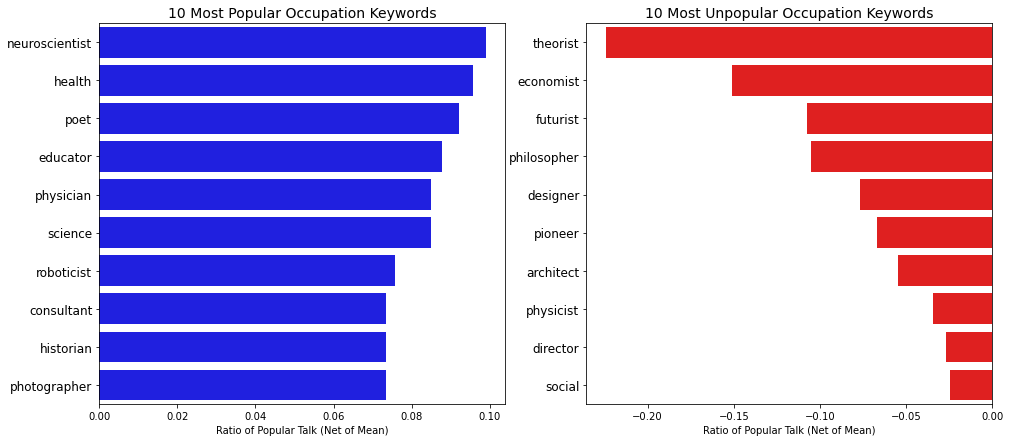

In [93]:

ted.loc[:,'occ'] = ted.speaker_occupation.copy()
ted.occ = ted.occ.fillna('Unknown')
ted.occ = ted.occ.str.replace('singer/songwriter', 'singer, songwriter')
ted.occ = ted.occ.str.replace('singer-songwriter', 'singer, songwriter')
count_vector2 = CountVectorizer(stop_words='english', min_df=20/len(ted))
occ_array = count_vector2.fit_transform(ted.occ).toarray()
occ_matrix = pd.DataFrame(occ_array, columns = count_vector2.get_feature_names())
all_occ = occ_matrix.columns
occ_matrix = pd.concat([occ_matrix, ted.Popular], axis=1)
by_occ = dict()
for col in all_occ:
    by_occ[col]=occ_matrix.groupby(col)['Popular'].mean()[1] - overall_mean_popular
occ_rank = pd.DataFrame.from_dict(by_occ, orient='index')
occ_rank.columns = ['pop_rate_diff']

plt.figure(figsize=(16,7))
plt.subplot(121)
bar_2 = occ_rank.sort_values(by='pop_rate_diff', ascending=False)[:10]
sns.barplot(x=bar_2.pop_rate_diff, y=bar_2.index, color='blue')
plt.title('10 Most Popular Occupation Keywords', fontsize=14)
plt.xlabel('Ratio of Popular Talk (Net of Mean)')
plt.yticks(fontsize=12)
plt.subplot(122)
bar_1 = occ_rank.sort_values(by='pop_rate_diff')[:10]
sns.barplot(x=bar_1.pop_rate_diff, y=bar_1.index, color='red')
plt.title('10 Most Unpopular Occupation Keywords', fontsize=14)
plt.xlabel('Ratio of Popular Talk (Net of Mean)')
plt.yticks(fontsize=12)
plt.show()

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Read in the Ted Talk Data again, but this time do not delete the non-TedTalks. Call this data set 'df'.

In [94]:
df = pd.read_csv("../Data/ted_main.csv")
df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views'],
      dtype='object')

In [95]:

df = df[['name', 'title', 'description', 'main_speaker', 'speaker_occupation', 'num_speaker', 'duration', 'event', 'film_date', 'published_date', 'comments', 'tags', 'languages', 'ratings', 'related_talks', 'url', 'views']]


In [96]:

import datetime
df['film_date'] = df['film_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))
df['published_date'] = df['published_date'].apply(lambda x: datetime.datetime.fromtimestamp( int(x)).strftime('%d-%m-%Y'))

In [97]:

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [98]:
df[['event']]

,event
0,TED2006
1,TED2006
2,TED2006
3,TED2006
4,TED2006
...,...
2545,TED2017
2546,TED2017
2547,TED2017
2548,TEDxMileHigh


In [99]:
df['month'] = df['film_date'].apply(lambda x: month_order[int(x.split('-')[1]) - 1])

month_df = pd.DataFrame(df['month'].value_counts()).reset_index()
month_df.columns = ['month', 'talks']

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Structure of the data

In [100]:
from scipy.stats import pearsonr

In [101]:
corr, _ = pearsonr(df['comments'], df['views']); corr # As can be seen, not much of a correlation between the two.

0.5309387006213678

In [102]:
# if we include all the talks will the correlation between comments and views increase or decrease?

corr, _ = pearsonr(ted['comments'], ted['views']); corr # it decreases!

0.5289031736657247

In [103]:
print("Number of non-Ted talks that we removed were:", len(df) - len(ted))

Number of non-Ted talks that we removed were: 111


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Data manipulation for predictive modelling. 

Look at all the variables and the data that is present in the dataset. Then evaluate which ones to keep as is, which ones outright delete, and which ones to keep but do some further data cleaning to make them usable.  

In [104]:
ted.columns

Index(['index', 'comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'event_cat', 'film_month', 'pub_month', 'film_year',
       'pub_year', 'film_weekday', 'pub_weekday', 'Funny', 'Beautiful',
       'Ingenious', 'Courageous', 'Longwinded', 'Confusing', 'Informative',
       'Fascinating', 'Unconvincing', 'Persuasive', 'Jaw-dropping', 'OK',
       'Obnoxious', 'Inspiring', 'positive', 'negative', 'pop_ratio',
       'Popular', 'occ'],
      dtype='object')

In [105]:
ted.head()

,index,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,...,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,positive,negative,pop_ratio,Popular,occ
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,2006-02-24,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,...,10704,4439,1174,209,24924,91539,1139,80.367867,1,Author/educator
1,1,265,With the same humor and humanity he exuded in ...,977,TED2006,2006-02-24,43,Al Gore,Al Gore: Averting the climate crisis,1,...,268,116,203,131,413,2170,565,3.840708,0,Climate advocate
2,2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,2006-02-23,26,David Pogue,David Pogue: Simplicity sells,1,...,230,54,146,142,230,2328,352,6.613636,1,Technology columnist
3,3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,2006-02-25,35,Majora Carter,Majora Carter: Greening the ghetto,1,...,460,230,85,35,1070,3488,157,22.216561,1,Activist for environmental justice
4,4,593,You've never seen data presented like this. Wi...,1190,TED2006,2006-02-21,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,...,2542,3736,248,61,2893,25063,311,80.588424,1,Global health expert; data visionary


In [106]:
drp_cols = ['index', 'description', 'event', 'film_date', 'main_speaker', 'name',
            'published_date', 'ratings', 'related_talks', 'speaker_occupation',
            'tags', 'title', 'url', 'film_month', 'film_weekday', 'pop_ratio',
            'occ']

drp_check =  [ 'description', 'event', 'film_date', 'main_speaker', 'name',
            'published_date', 'ratings', 'related_talks', 'speaker_occupation',
            'tags', 'title', 'film_month', 'film_weekday', 'pop_ratio',
            'occ']

for var in drp_check:
    print(var)
    print('number of unique entries: ' , len( ted[var].unique() ) )
    print(ted[var].head())
    print()
    
    
#len((ted.event.unique()))

description
number of unique entries:  2439
0    Sir Ken Robinson makes an entertaining and pro...
1    With the same humor and humanity he exuded in ...
2    New York Times columnist David Pogue takes aim...
3    In an emotionally charged talk, MacArthur-winn...
4    You've never seen data presented like this. Wi...
Name: description, dtype: object

event
number of unique entries:  315
0    TED2006
1    TED2006
2    TED2006
3    TED2006
4    TED2006
Name: event, dtype: object

film_date
number of unique entries:  673
0    2006-02-24
1    2006-02-24
2    2006-02-23
3    2006-02-25
4    2006-02-21
Name: film_date, dtype: object

main_speaker
number of unique entries:  2071
0     Ken Robinson
1          Al Gore
2      David Pogue
3    Majora Carter
4     Hans Rosling
Name: main_speaker, dtype: object

name
number of unique entries:  2439
0        Ken Robinson: Do schools kill creativity?
1             Al Gore: Averting the climate crisis
2                    David Pogue: Simplicity sells

## Create variable number of days past since video published. 

In [108]:
ted.columns

Index(['index', 'comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views', 'event_cat', 'film_month', 'pub_month', 'film_year',
       'pub_year', 'film_weekday', 'pub_weekday', 'Funny', 'Beautiful',
       'Ingenious', 'Courageous', 'Longwinded', 'Confusing', 'Informative',
       'Fascinating', 'Unconvincing', 'Persuasive', 'Jaw-dropping', 'OK',
       'Obnoxious', 'Inspiring', 'positive', 'negative', 'pop_ratio',
       'Popular', 'occ'],
      dtype='object')

In [112]:
type(ted.published_date[0])
today_date = datetime.date.today()
date_diff = today_date - ted['published_date']
print(type(ted['published_date'][0]))
print(ted['published_date'][0])
print(type(date_diff))
print(date_diff[0].days)
print(type(date_diff))
#print(ted[['published_date']].years.value_counts)
print(ted.pub_year.value_counts())
#print(ted.pub_year.value_counts())

<class 'datetime.date'>
2006-06-26
<class 'pandas.core.series.Series'>
5446
<class 'pandas.core.series.Series'>
2012    303
2011    248
2013    243
2014    240
2016    239
2010    216
2015    215
2009    205
2017    197
2008    162
2007    121
2006     50
Name: pub_year, dtype: int64


In [ ]:
#ted['days_since_published'] = date_diff.days

<AxesSubplot:xlabel='pub_year', ylabel='views'>

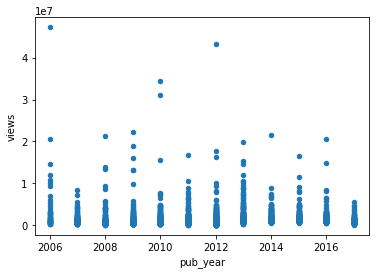

In [115]:
ted.plot(kind = 'scatter', x = 'pub_year', y = 'views')

Looking at the trend of the data in the plot above, treating pub_year as a categorical variable should be a better model. 

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Drop redundant columns, uninformative columns, and NLP columns which we will not use for the current deep learning model as we are only using tabular data for this version of the deep neural network. 

Later we will use the NLP columns and tabular data together in the deep learning model performing prediction using NLP and and tabular data will then need these NLP columns such as 'description', 'tags', 'title', etc. 


In [116]:
ted_df = ted

drp_cols = ['index', 'description', 'event', 'film_date', 'main_speaker', 'name',
            'published_date', 'ratings', 'related_talks', 'speaker_occupation',
            'tags', 'title', 'url', 'film_year', 'film_month', 'film_weekday', 'occ'] 



ted_df = ted_df.drop(drp_cols, axis=1)
ted_df.head()

,comments,duration,languages,num_speaker,views,event_cat,pub_month,pub_year,pub_weekday,Funny,...,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,positive,negative,pop_ratio,Popular
0,4553,1164,60,1,47227110,TED,6,2006,0,19645,...,300,10704,4439,1174,209,24924,91539,1139,80.367867,1
1,265,977,43,1,3200520,TED,6,2006,0,544,...,258,268,116,203,131,413,2170,565,3.840708,0
2,124,1286,26,1,1636292,TED,6,2006,0,964,...,104,230,54,146,142,230,2328,352,6.613636,1
3,200,1116,35,1,1697550,TED,6,2006,0,59,...,36,460,230,85,35,1070,3488,157,22.216561,1
4,593,1190,48,1,12005869,TED,6,2006,1,1390,...,67,2542,3736,248,61,2893,25063,311,80.588424,1


In [117]:
# one-hot encode the catgorical variables
months = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
          'Nov', 'Dec']
weekdays = ['Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
ted_df = pd.concat([ted_df, pd.get_dummies(ted_df['event_cat'], drop_first = True)],axis=1)
ted_df = pd.concat([ted_df, pd.get_dummies(ted_df['pub_year'], prefix='Year', drop_first=True)],axis=1)
ted_df = pd.concat([ted_df, pd.get_dummies(ted_df['pub_month'], prefix='Month', drop_first=True)],axis=1)
ted_df = pd.concat([ted_df, pd.get_dummies(ted_df['pub_weekday'], prefix='Weekday', drop_first=True)],axis=1)
ted_df = ted_df.drop(['event_cat', 'pub_month', 'pub_weekday', 'pub_year'], axis=1)
ted_df.head()

,comments,duration,languages,num_speaker,views,Funny,Beautiful,Ingenious,Courageous,Longwinded,...,Month_9,Month_10,Month_11,Month_12,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,4553,1164,60,1,47227110,19645,4573,6073,3253,387,...,0,0,0,0,0,0,0,0,0,0
1,265,977,43,1,3200520,544,58,56,139,113,...,0,0,0,0,0,0,0,0,0,0
2,124,1286,26,1,1636292,964,60,183,45,78,...,0,0,0,0,0,0,0,0,0,0
3,200,1116,35,1,1697550,59,291,105,760,53,...,0,0,0,0,0,0,0,0,0,0
4,593,1190,48,1,12005869,1390,942,3202,318,110,...,0,0,0,0,1,0,0,0,0,0


In [118]:
ted_df.columns

Index(['comments', 'duration', 'languages', 'num_speaker', 'views', 'Funny',
       'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing',
       'Informative', 'Fascinating', 'Unconvincing', 'Persuasive',
       'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring', 'positive', 'negative',
       'pop_ratio', 'Popular', 'TEDx', 'Year_2007', 'Year_2008', 'Year_2009',
       'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014',
       'Year_2015', 'Year_2016', 'Year_2017', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12', 'Weekday_1', 'Weekday_2', 'Weekday_3',
       'Weekday_4', 'Weekday_5', 'Weekday_6'],
      dtype='object')

In [119]:
ted_df.shape

(2439, 52)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Separate the data into Train and Test sets.

In [120]:
from sklearn.model_selection import train_test_split

In [121]:
# Choose which data set to use.
dataset = ted_df

# Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('views',axis = 1), 
                                                    dataset.views, test_size=0.2, random_state=1)

In [122]:
for set in [X_train, X_test, y_train, y_test]:
    #print( len(set))
    print(set.shape)

(1951, 51)
(488, 51)
(1951,)
(488,)


# split the sets by randomly choosing the row index
msk = np.random.rand(len(ted_df)) < 0.8

# split the data screened by the autoencoder
X_train_1 = df_encoded[msk].drop(['views'], axis = 1)
y_train_1 = df_encoded[msk]['views']
X_test_1 = df_encoded[~msk].drop(['views'], axis = 1)
y_test_1 = df_encoded[~msk]['views']

# split the data screened by the PCA
X_train_2 = df_pca[msk].drop(['views'], axis = 1)
y_train_2 = df_pca[msk]['views']
X_test_2 = df_pca[~msk].drop(['views'], axis = 1)
y_test_2 = df_pca[~msk]['views']

# split the data screened by the TSEN
X_train_3 = df_pca[msk].drop(['views'], axis = 1)
y_train_3 = df_pca[msk]['views']
X_test_3 = df_pca[~msk].drop(['views'], axis = 1)
y_test_3 = df_pca[~msk]['views']

# write out these data sets
X_train_1.to_csv(r'/content/X_train_1.csv', index = False)
y_train_1.to_csv(r'/content/y_train_1.csv', index = False)
X_test_1.to_csv(r'/content/X_test_1.csv', index = False)
y_test_1.to_csv(r'/content/y_test_1.csv', index = False)

X_train_2.to_csv(r'/content/X_train_2.csv', index = False)
y_train_2.to_csv(r'/content/y_train_2.csv', index = False)
X_test_2.to_csv(r'/content/X_test_2.csv', index = False)
y_test_2.to_csv(r'/content/y_test_2.csv', index = False)

X_train_3.to_csv(r'/content/X_train_3.csv', index = False)
y_train_3.to_csv(r'/content/y_train_3.csv', index = False)
X_test_3.to_csv(r'/content/X_test_3.csv', index = False)
y_test_3.to_csv(r'/content/y_test_3.csv', index = False)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)## After seperating the data need to normalize the continuous variables separately for train and test sets. 

Hopefully this will improve the performance.

In [123]:
ted_df.describe()

,comments,duration,languages,num_speaker,views,Funny,Beautiful,Ingenious,Courageous,Longwinded,...,Month_9,Month_10,Month_11,Month_12,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
count,2439.000000,2439.000000,2439.000000,2439.000000,2.439000e+03,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,...,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.00000,2439.000000
mean,192.348913,810.909799,27.703977,1.029520,1.729835e+06,153.205412,192.441574,152.240262,165.728167,32.300123,...,0.091431,0.086921,0.072571,0.062321,0.205412,0.185732,0.185322,0.162362,0.01763,0.050021
std,285.669320,331.877489,9.205526,0.212291,2.537226e+06,597.991058,479.678205,286.885388,434.044810,41.839807,...,0.288280,0.281777,0.259484,0.241787,0.404085,0.388970,0.388638,0.368858,0.13163,0.218032
min,2.000000,135.000000,0.000000,1.000000,6.666800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,63.000000,573.000000,23.000000,1.000000,7.788850e+05,8.000000,26.000000,26.000000,20.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,118.000000,840.000000,28.000000,1.000000,1.140425e+06,21.000000,68.000000,70.000000,52.000000,19.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,220.000000,1037.500000,33.000000,1.000000,1.724469e+06,90.000000,189.500000,172.000000,150.000000,40.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,6404.000000,3608.000000,72.000000,5.000000,4.722711e+07,19645.000000,9437.000000,6073.000000,8668.000000,447.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Data Dimentionality Reduction

#### Method #1: Autoencoder Neural Network:  a deep learning approach

In [124]:
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

In [125]:
X = ted_df.drop(['views'], axis=1)
Y = ted_df['views']

# check the current data dimension
raw_dim = X.shape[1] # 39 features

# specify the encoding dimension
encoding_dim = 16

# Scale each feature into the range of [0, 1]
scl_X = minmax_scale(X, axis = 0)

# define the layers in the autoencoder NN
input = Input(shape = (39,))
encoder_1 = Dense(32, activation = 'relu')(input)
encoder_2 = Dense(16, activation = 'sigmoid')(encoder_1)
decoder_1 = Dense(32, activation = 'relu')(encoder_2)
decoder_2 = Dense(39, activation = 'sigmoid')(decoder_1)

# define the autoencoder model
autoencoder = Model(input, decoder_2)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# define the intermediate encoded results
encoder = Model(input, encoder_2)

# train the autoencoder
autoencoder.fit(scl_X, scl_X, epochs=250, batch_size=10, shuffle=True)

# get the dimension reduced data
df_encoded = pd.concat([pd.DataFrame(encoder.predict(scl_X)), Y], axis = 1)

#### Method #2: Principle Component Analysis: a machine learning approach

In [85]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardize and normalize each feature so that they have comparative variance
scale= StandardScaler()
X_scl = scale.fit_transform(X)
# perform the PC transformation
pca = PCA(n_components=12)
df_pca = pd.concat([pd.DataFrame(pca.fit_transform(X_scl)), Y], axis = 1)

#### Method #3: T-distributed Stochastic Neighbor Embedding: a statistical approach. 

In [95]:
from sklearn.manifold import TSNE

# perform the PC transformation
tsen = TSNE(n_components=3)
df_tsen = pd.concat([pd.DataFrame(tsen.fit_transform(X_scl)), Y], axis = 1)

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Building a Deep Neural Network

We will build a deep neural network. The first one we will build will be of 6 hidden layers. For the 6 layer neural network we will do a hyperparameter search. The optimzed hyperparameter we will then use for all the subsequent deep neural networks. We will try deep neural networks with 12, 24, and 50 hidden layers.

Hidden Layers:
1. 6
2. 12
3. 24
4. 50

Use for loops to vary the number of hidden layers. 



In [128]:
import pathlib
import tempfile
import os

In [129]:
cwd = os.getcwd()
print(cwd)

C:\Users\cubes\OneDrive\Reseach\deeplearning\Report3_tedtalk_project\mnn


In [130]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [131]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"

In [47]:
model_name = "mdnn_6hl_rectangle_archi_defaulthyperpara_{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(model_name))
print(model_name)

mdnn_6hl_rectangle_archi_defaulthyperpara_1621820353


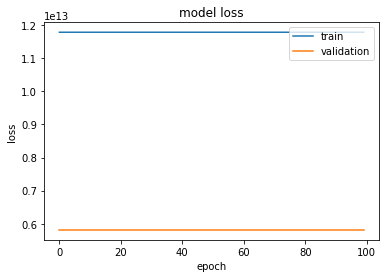

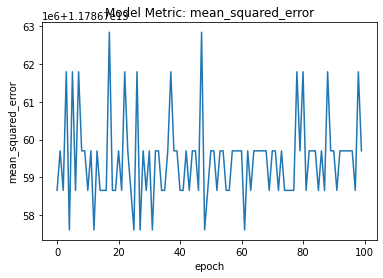

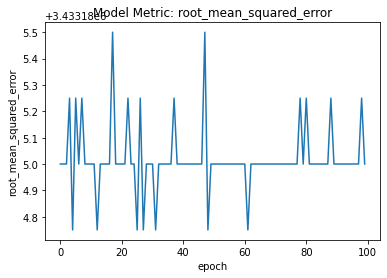

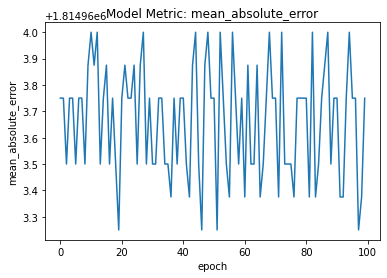

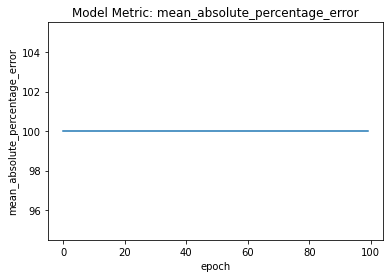

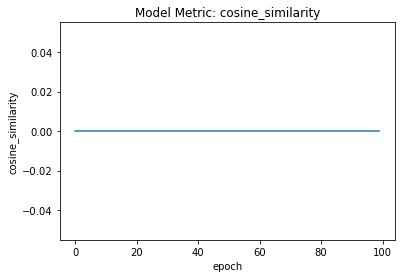

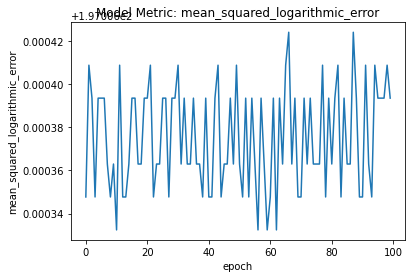

,model_num,model_name,optimizer,loss_fn,activation_fn,output_activation_fn,epochs,batch_size,validation_split,input_dimensions,...,num_hiddenlayer,neurons_in_hiddenlayer,num_dropout_layers,loss,mse_test,mae_test,mape_test,cosine_similarity_test,rmse_test,msle_test
0,0,mdnn_6hl_rectangle_archi_defaulthyperpara_1621...,nadam,mse,relu,relu,100,32,0.2,40,...,6,40,0,4.781299e+12,4.781299e+12,1556715.875,100.0,0.0,2186618.25,195.806717


In [48]:
def model_results(model_num,

                  #X_train = X_train,
                  #y_train = y_train,
                  #X_test = X_test,
                  #y_test = y_test,
                  model_name = 'model_name',
                  optimizer='nadam',
                  loss_fn='mse',
                  activation_fn='relu',
                  output_activation_fn='relu',

                  epochs=100,
                  batch_size=32,
                  validation_split=0.2,

                  neurons_in_inputlayer=50,
                  num_hiddenlayer=6,
                  neurons_in_hiddenlayer=40,
                  num_dropout_layers=0,

                  verbose=0):
    # The Model

    input_dimensions = X_train.shape[1]
    
    #model_name = "Views_6hl_inverted_triangle_archi_defaulthyperpara_{}".format(int(time.time()))
    tensorboard = TensorBoard(log_dir='logs/{}'.format(model_name))

    model = Sequential()
    # Input Layer
    model.add(Dense(neurons_in_inputlayer, input_dim=input_dimensions, activation=activation_fn))
    # Dropout Layer
    #model.add(Dropout(rate = 0.1,seed=100))

    # Hidden Layers

    for i in range(num_hiddenlayer-1):
        
        model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

        
    # Output Layer
    model.add(Dense(1, activation=output_activation_fn))

    # Compiling the model
    model.compile(loss=loss_fn, optimizer=optimizer,
                  #metrics=['mse', 'mae', 'mape', CosineSimilarity(), RootMeanSquaredError() , MeanSquaredLogarithmicError() ])
                  metrics=[MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()
                      , CosineSimilarity(), RootMeanSquaredError(), MeanSquaredLogarithmicError()])

    # Train the model and make predictions
    model_fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                          validation_split=validation_split, callbacks = [tensorboard])
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=verbose)

    # Make predictions from the trained model
    #predictions = model.predict(X_test)

    # Store results
    dict = {'model_num': [model_num],
            'model_name': [model_name],
            'optimizer': [optimizer],
            'loss_fn': [loss_fn],
            'activation_fn': [activation_fn],
            'output_activation_fn': [output_activation_fn],
            'epochs': [epochs],
            'batch_size': [batch_size],
            'validation_split': [validation_split],
            'input_dimensions': [input_dimensions],
            'neurons_in_inputlayer': [neurons_in_inputlayer],
            'num_hiddenlayer': [num_hiddenlayer],
            'neurons_in_hiddenlayer': [neurons_in_hiddenlayer],
            'num_dropout_layers': [num_dropout_layers],
            'loss': [score[0]],
            'mse_test': [score[1]],
            'mae_test': [score[2]],
            'mape_test': [score[3]],
            'cosine_similarity_test': [score[4]],
            'rmse_test': [score[5]],
            'msle_test': [score[6]]
            }


    # Add Option to not plot this.
    # "Plot Loss"
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # Add option to not plot this.
    # Plot metrics
    for metric in ['mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error',
                   'mean_absolute_percentage_error', 'cosine_similarity', 'mean_squared_logarithmic_error']:
        plt.plot(model_fit.history[metric])
        plt.title('Model Metric: ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        #plt.plot(model_fit.history['mean_squared_error'])
        #plt.plot(model_fit.history['mean_absolute_error'])
        #plt.plot(model_fit.history['mean_absolute_percentage_error'])
        #pyplot.plot(model_fit.history['cosine_proximity'])
        plt.show()

    results_df = pd.DataFrame(dict)
    #print ("After Training:", list(zip(model.metrics_names, score)))
    return (results_df)

model_name = "mdnn_6hl_rectangle_archi_defaulthyperpara_{}".format(int(time.time()))
model_0 = model_results(model_num = 0, model_name = model_name)
model_0

# rmse: 915,440.81 for 7 hidden layers.
# rmse: 945,274.75 for 6 hidden layers.

In [49]:
model_0['rmse_test']

0    2186618.25
Name: rmse_test, dtype: float64

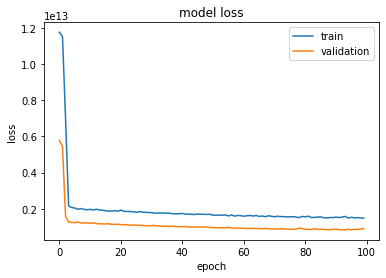

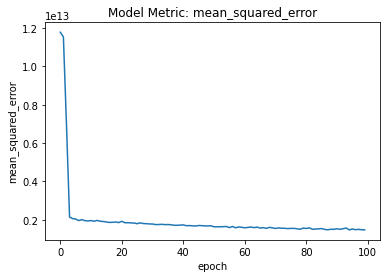

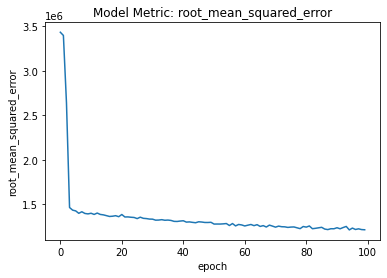

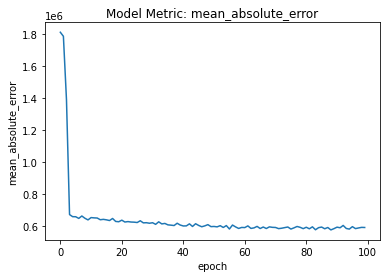

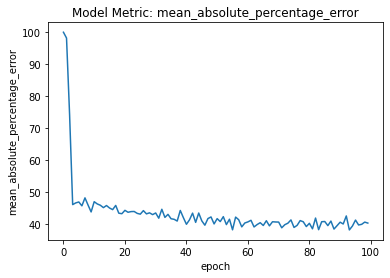

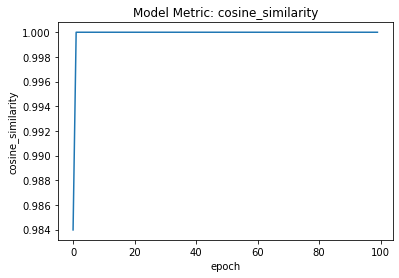

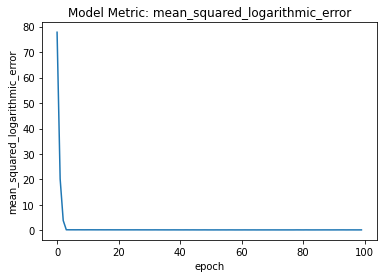

,model_num,model_name,optimizer,loss_fn,activation_fn,output_activation_fn,epochs,batch_size,validation_split,input_dimensions,...,num_hiddenlayer,neurons_in_hiddenlayer,num_dropout_layers,loss,mse_test,mae_test,mape_test,cosine_similarity_test,rmse_test,msle_test
0,1,mdnn_6hl_inverted_triangle_archi_defaulthyperp...,nadam,mse,relu,relu,100,32,0.2,40,...,6,40,0,7.955688e+11,7.955688e+11,547036.8125,44.449894,1.0,891946.625,0.23589


In [55]:
def model_results_triangle_1(model_num,

                  #X_train = X_train,
                  #y_train = y_train,
                  #X_test = X_test,
                  #y_test = y_test,
                  model_name = 'model_name',
                  optimizer='nadam',
                  loss_fn='mse',
                  activation_fn='relu',
                  output_activation_fn='relu',

                  epochs=100,
                  batch_size=32,
                  validation_split=0.2,

                  neurons_in_inputlayer=50,
                  num_hiddenlayer=6,
                  neurons_in_hiddenlayer=40,
                  num_dropout_layers=0,

                  verbose=0):
    # The Model

    input_dimensions = X_train.shape[1]
    
    tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

    model = Sequential()
    # Input Layer
    model.add(Dense(neurons_in_inputlayer, input_dim=input_dimensions, activation=activation_fn))
    # Dropout Layer
    #model.add(Dropout(rate = 0.1,seed=100))

    # Hidden Layers

    #for i in range(num_hiddenlayer):
        
    #    model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/2, activation=activation_fn))
    
    model.add(Dense(neurons_in_hiddenlayer/2, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/4, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/10, activation=activation_fn))

    # Output Layer
    model.add(Dense(1, activation=output_activation_fn))

    # Compiling the model
    model.compile(loss=loss_fn, optimizer=optimizer,
                  #metrics=['mse', 'mae', 'mape', CosineSimilarity(), RootMeanSquaredError() , MeanSquaredLogarithmicError() ])
                  metrics=[MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()
                      , CosineSimilarity(), RootMeanSquaredError(), MeanSquaredLogarithmicError()])

    # Train the model and make predictions
    model_fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                          validation_split=validation_split, callbacks = [tensorboard])
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=verbose)

    # Make predictions from the trained model
    #predictions = model.predict(X_test)

    # Store results
    dict = {'model_num': [model_num],
            'model_name': [model_name],
            'optimizer': [optimizer],
            'loss_fn': [loss_fn],
            'activation_fn': [activation_fn],
            'output_activation_fn': [output_activation_fn],
            'epochs': [epochs],
            'batch_size': [batch_size],
            'validation_split': [validation_split],
            'input_dimensions': [input_dimensions],
            'neurons_in_inputlayer': [neurons_in_inputlayer],
            'num_hiddenlayer': [num_hiddenlayer],
            'neurons_in_hiddenlayer': [neurons_in_hiddenlayer],
            'num_dropout_layers': [num_dropout_layers],
            'loss': [score[0]],
            'mse_test': [score[1]],
            'mae_test': [score[2]],
            'mape_test': [score[3]],
            'cosine_similarity_test': [score[4]],
            'rmse_test': [score[5]],
            'msle_test': [score[6]]
            }


    # Add Option to not plot this.
    # "Plot Loss"
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # Add option to not plot this.
    # Plot metrics
    for metric in ['mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error',
                   'mean_absolute_percentage_error', 'cosine_similarity', 'mean_squared_logarithmic_error']:
        plt.plot(model_fit.history[metric])
        plt.title('Model Metric: ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        #plt.plot(model_fit.history['mean_squared_error'])
        #plt.plot(model_fit.history['mean_absolute_error'])
        #plt.plot(model_fit.history['mean_absolute_percentage_error'])
        #pyplot.plot(model_fit.history['cosine_proximity'])
        plt.show()

    results_df = pd.DataFrame(dict)
    #print ("After Training:", list(zip(model.metrics_names, score)))
    return (results_df)

NAME = "mdnn_6hl_inverted_triangle_archi_defaulthyperpara_{}".format(int(time.time()))
model_6 = model_results_triangle_1(model_num = 1, model_name = NAME)
model_6

In [56]:
model_6

,model_num,model_name,optimizer,loss_fn,activation_fn,output_activation_fn,epochs,batch_size,validation_split,input_dimensions,...,num_hiddenlayer,neurons_in_hiddenlayer,num_dropout_layers,loss,mse_test,mae_test,mape_test,cosine_similarity_test,rmse_test,msle_test
0,1,mdnn_6hl_inverted_triangle_archi_defaulthyperp...,nadam,mse,relu,relu,100,32,0.2,40,...,6,40,0,7.955688e+11,7.955688e+11,547036.8125,44.449894,1.0,891946.625,0.23589


In [57]:
print(model_6['rmse_test'])

0    891946.625
Name: rmse_test, dtype: float64


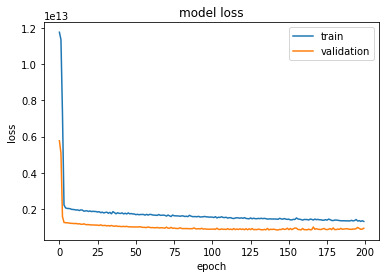

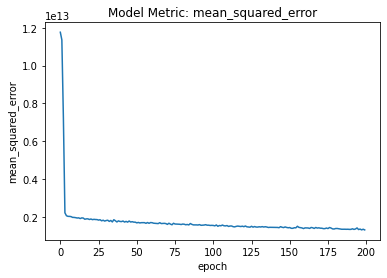

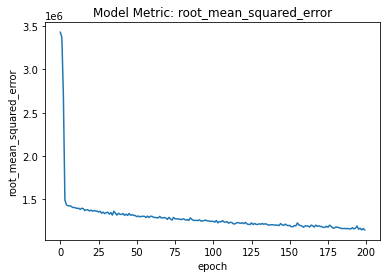

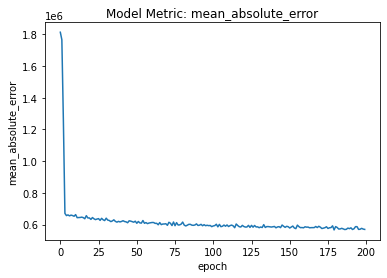

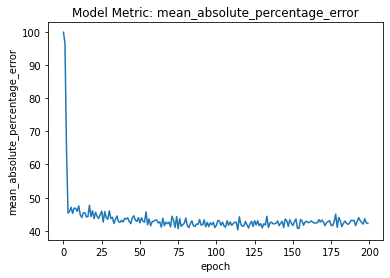

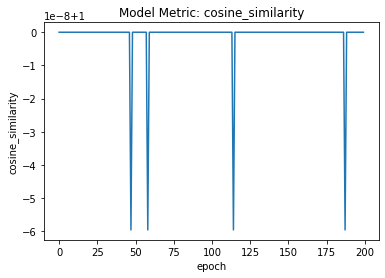

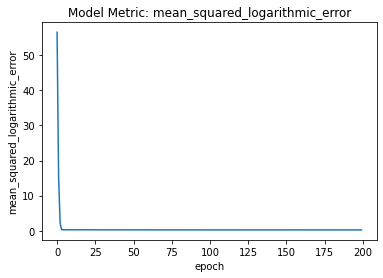

,model_num,model_name,optimizer,loss_fn,activation_fn,output_activation_fn,epochs,batch_size,validation_split,input_dimensions,...,num_hiddenlayer,neurons_in_hiddenlayer,num_dropout_layers,loss,mse_test,mae_test,mape_test,cosine_similarity_test,rmse_test,msle_test
0,1,mdnn_6hl_inverted_triangle_archi_epochs200_162...,nadam,mse,relu,relu,200,32,0.2,40,...,6,40,0,8.994347e+11,8.994347e+11,561538.0625,47.320225,1.0,948385.3125,0.235401


In [61]:
NAME = "mdnn_6hl_inverted_triangle_archi_epochs200_{}".format(int(time.time()))
model_7 = model_results_triangle_1(model_num = 1, model_name = NAME, epochs=200 )
model_7

In [62]:
model_7['rmse_test']

0    948385.3125
Name: rmse_test, dtype: float64

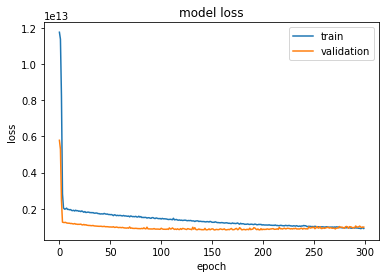

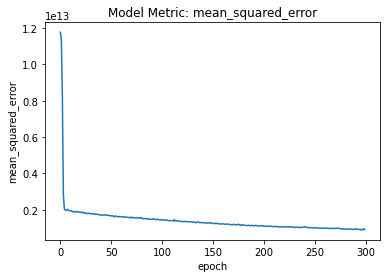

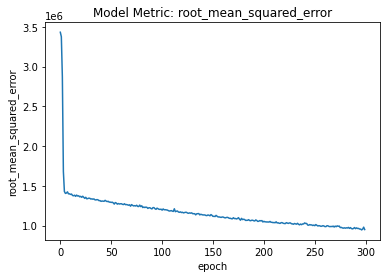

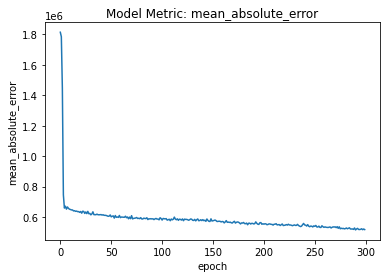

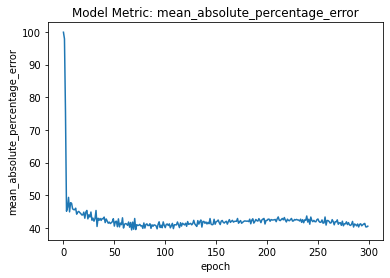

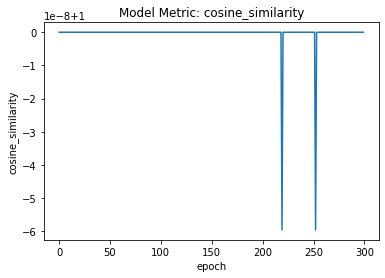

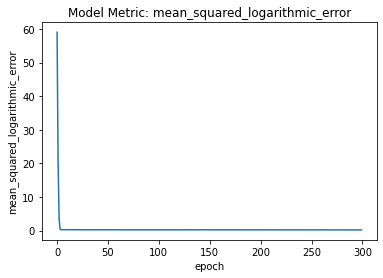

,model_num,model_name,optimizer,loss_fn,activation_fn,output_activation_fn,epochs,batch_size,validation_split,input_dimensions,...,num_hiddenlayer,neurons_in_hiddenlayer,num_dropout_layers,loss,mse_test,mae_test,mape_test,cosine_similarity_test,rmse_test,msle_test
0,1,mdnn_6hl_inverted_triangle_archi_epochs300_162...,nadam,mse,relu,relu,300,32,0.2,40,...,6,40,0,1.009883e+12,1.009883e+12,530139.4375,42.991924,1.0,1.004929e+06,0.209085


In [64]:
NAME = "mdnn_6hl_inverted_triangle_archi_epochs300_{}".format(int(time.time()))
model_8 = model_results_triangle_1(model_num = 1, model_name = NAME, epochs=300 )
model_8

In [67]:
model_8['rmse_test']

0    1.004929e+06
Name: rmse_test, dtype: float64

In [68]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 16484), started 1:08:07 ago. (Use '!kill 16484' to kill it.)

In my opinion looking at the worse rmse found for deep neural network with 6 and 7 hidden layers seems to be an indication that there are way too many parameters than data. 

We will create slightly smaller neural newtorks and optimize those. Hopefully obtain rmse less than 600K.

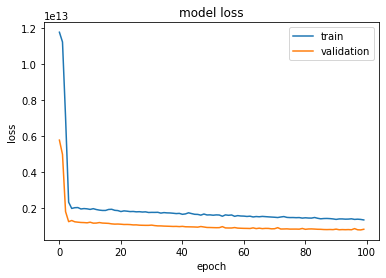

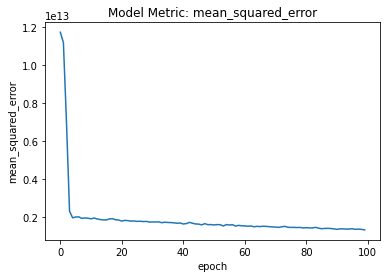

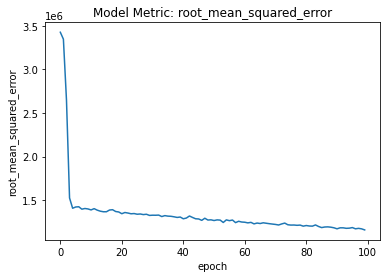

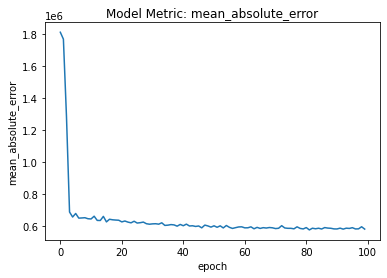

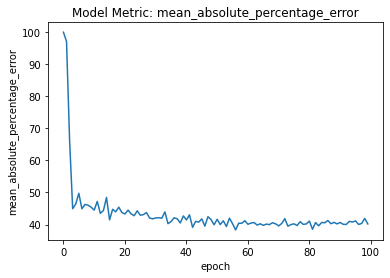

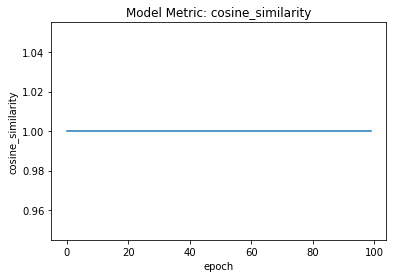

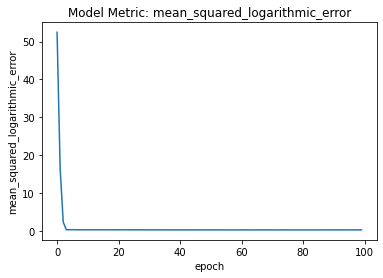

,model_num,model_name,optimizer,loss_fn,activation_fn,output_activation_fn,epochs,batch_size,validation_split,input_dimensions,...,num_hiddenlayer,neurons_in_hiddenlayer,num_dropout_layers,loss,mse_test,mae_test,mape_test,cosine_similarity_test,rmse_test,msle_test
0,4,mdnn_5hl_inverted_triangle_archi_2_defaulthype...,nadam,mse,relu,relu,100,32,0.2,40,...,6,40,0,7.910462e+11,7.910462e+11,536739.9375,43.517738,1.0,889407.75,0.229301


In [70]:
def model_results_triangle_2(model_num,

                  #X_train = X_train,
                  #y_train = y_train,
                  #X_test = X_test,
                  #y_test = y_test,
                  model_name = 'model_name',
                  optimizer='nadam',
                  loss_fn='mse',
                  activation_fn='relu',
                  output_activation_fn='relu',

                  epochs=100,
                  batch_size=32,
                  validation_split=0.2,

                  neurons_in_inputlayer=50,
                  num_hiddenlayer=6,
                  neurons_in_hiddenlayer=40,
                  num_dropout_layers=0,

                  verbose=0):
    # The Model

    input_dimensions = X_train.shape[1]
    
    tensorboard = TensorBoard(log_dir='logs/{}'.format(model_name))

    model = Sequential()
    # Input Layer
    model.add(Dense(input_dimensions, input_dim=input_dimensions, activation=activation_fn))
    # Dropout Layer
    #model.add(Dropout(rate = 0.1,seed=100))

    # Hidden Layers

    model.add(Dense(neurons_in_hiddenlayer/2, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/4, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/10, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/20, activation=activation_fn))

    # Output Layer
    model.add(Dense(1, activation=output_activation_fn))

    # Compiling the model
    model.compile(loss=loss_fn, optimizer=optimizer,
                  #metrics=['mse', 'mae', 'mape', CosineSimilarity(), RootMeanSquaredError() , MeanSquaredLogarithmicError() ])
                  metrics=[MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()
                      , CosineSimilarity(), RootMeanSquaredError(), MeanSquaredLogarithmicError()])

    # Train the model and make predictions
    model_fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                          validation_split=validation_split, callbacks = [tensorboard])
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=verbose)

    # Make predictions from the trained model
    #predictions = model.predict(X_test)

    # Store results
    dict = {'model_num': [model_num],
            'model_name': [model_name],
            'optimizer': [optimizer],
            'loss_fn': [loss_fn],
            'activation_fn': [activation_fn],
            'output_activation_fn': [output_activation_fn],
            'epochs': [epochs],
            'batch_size': [batch_size],
            'validation_split': [validation_split],
            'input_dimensions': [input_dimensions],
            'neurons_in_inputlayer': [neurons_in_inputlayer],
            'num_hiddenlayer': [num_hiddenlayer],
            'neurons_in_hiddenlayer': [neurons_in_hiddenlayer],
            'num_dropout_layers': [num_dropout_layers],
            'loss': [score[0]],
            'mse_test': [score[1]],
            'mae_test': [score[2]],
            'mape_test': [score[3]],
            'cosine_similarity_test': [score[4]],
            'rmse_test': [score[5]],
            'msle_test': [score[6]]
            }


    # Add Option to not plot this.
    # "Plot Loss"
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # Add option to not plot this.
    # Plot metrics
    for metric in ['mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error',
                   'mean_absolute_percentage_error', 'cosine_similarity', 'mean_squared_logarithmic_error']:
        plt.plot(model_fit.history[metric])
        plt.title('Model Metric: ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        #plt.plot(model_fit.history['mean_squared_error'])
        #plt.plot(model_fit.history['mean_absolute_error'])
        #plt.plot(model_fit.history['mean_absolute_percentage_error'])
        #pyplot.plot(model_fit.history['cosine_proximity'])
        plt.show()

    results_df = pd.DataFrame(dict)
    #print ("After Training:", list(zip(model.metrics_names, score)))
    return (results_df)

NAME = "mdnn_5hl_inverted_triangle_archi_2_defaulthyperpara_{}".format(int(time.time()))
model_9 = model_results_triangle_1(model_num = 4, model_name = NAME)
model_9

In [71]:
model_9['rmse_test']

0    889407.75
Name: rmse_test, dtype: float64

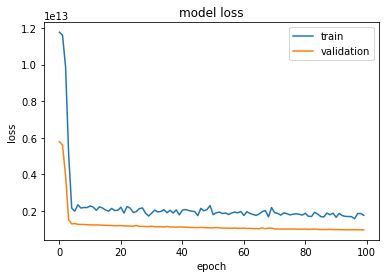

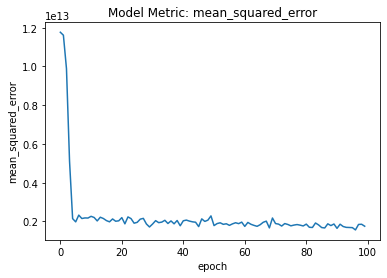

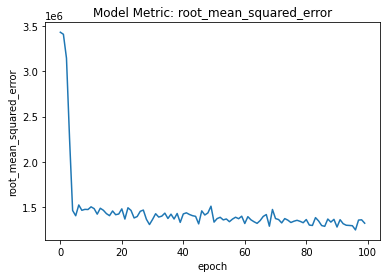

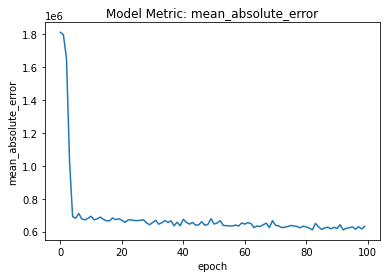

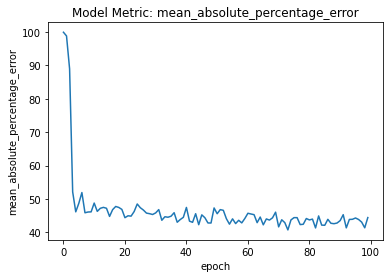

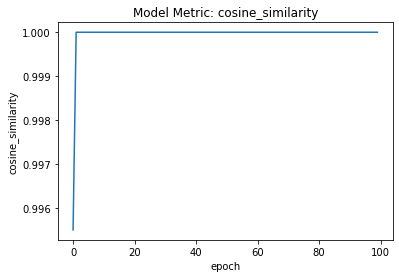

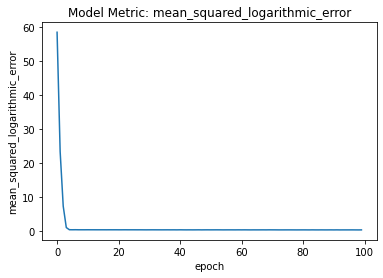

,model_num,model_name,optimizer,loss_fn,activation_fn,output_activation_fn,epochs,batch_size,validation_split,input_dimensions,...,num_hiddenlayer,neurons_in_hiddenlayer,num_dropout_layers,loss,mse_test,mae_test,mape_test,cosine_similarity_test,rmse_test,msle_test
0,5,mdnn_5hl_inverted_triangle_archi_2_dropout_def...,nadam,mse,relu,relu,100,32,0.2,40,...,6,40,1,6.353424e+11,6.353424e+11,489958.125,38.990826,1.0,797083.6875,0.210531


In [74]:
def model_results_triangle_2_dropout(model_num,

                  #X_train = X_train,
                  #y_train = y_train,
                  #X_test = X_test,
                  #y_test = y_test,
                  model_name = 'model_name',
                  optimizer='nadam',
                  loss_fn='mse',
                  activation_fn='relu',
                  output_activation_fn='relu',

                  epochs=100,
                  batch_size=32,
                  validation_split=0.2,

                  neurons_in_inputlayer=50,
                  num_hiddenlayer=6,
                  neurons_in_hiddenlayer=40,
                  num_dropout_layers=1,

                  verbose=0):
    # The Model

    input_dimensions = X_train.shape[1]
    
    tensorboard = TensorBoard(log_dir='logs/{}'.format(model_name))

    model = Sequential()
    # Input Layer
    model.add(Dense(neurons_in_inputlayer, input_dim=input_dimensions, activation=activation_fn))
    # Dropout Layer
    #model.add(Dropout(rate = 0.1,seed=100))

    # Hidden Layers

    #for i in range(num_hiddenlayer):
        
    #    model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/2, activation=activation_fn))
    
    model.add(Dropout(.1)) # add a dropout layer
    
    model.add(Dense(neurons_in_hiddenlayer/4, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/10, activation=activation_fn))

    model.add(Dense(neurons_in_hiddenlayer/20, activation=activation_fn))

    # Output Layer
    model.add(Dense(1, activation=output_activation_fn))

    # Compiling the model
    model.compile(loss=loss_fn, optimizer=optimizer,
                  #metrics=['mse', 'mae', 'mape', CosineSimilarity(), RootMeanSquaredError() , MeanSquaredLogarithmicError() ])
                  metrics=[MeanSquaredError(), MeanAbsoluteError(), MeanAbsolutePercentageError()
                      , CosineSimilarity(), RootMeanSquaredError(), MeanSquaredLogarithmicError()])

    # Train the model and make predictions
    model_fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                          validation_split=validation_split, callbacks = [tensorboard])
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=verbose)

    # Make predictions from the trained model
    #predictions = model.predict(X_test)

    # Store results
    dict = {'model_num': [model_num],
            'model_name': [model_name],
            'optimizer': [optimizer],
            'loss_fn': [loss_fn],
            'activation_fn': [activation_fn],
            'output_activation_fn': [output_activation_fn],
            'epochs': [epochs],
            'batch_size': [batch_size],
            'validation_split': [validation_split],
            'input_dimensions': [input_dimensions],
            'neurons_in_inputlayer': [neurons_in_inputlayer],
            'num_hiddenlayer': [num_hiddenlayer],
            'neurons_in_hiddenlayer': [neurons_in_hiddenlayer],
            'num_dropout_layers': [num_dropout_layers],
            'loss': [score[0]],
            'mse_test': [score[1]],
            'mae_test': [score[2]],
            'mape_test': [score[3]],
            'cosine_similarity_test': [score[4]],
            'rmse_test': [score[5]],
            'msle_test': [score[6]]
            }


    # Add Option to not plot this.
    # "Plot Loss"
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # Add option to not plot this.
    # Plot metrics
    for metric in ['mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error',
                   'mean_absolute_percentage_error', 'cosine_similarity', 'mean_squared_logarithmic_error']:
        plt.plot(model_fit.history[metric])
        plt.title('Model Metric: ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        #plt.plot(model_fit.history['mean_squared_error'])
        #plt.plot(model_fit.history['mean_absolute_error'])
        #plt.plot(model_fit.history['mean_absolute_percentage_error'])
        #pyplot.plot(model_fit.history['cosine_proximity'])
        plt.show()

    results_df = pd.DataFrame(dict)
    #print ("After Training:", list(zip(model.metrics_names, score)))
    return (results_df)

NAME = "mdnn_5hl_inverted_triangle_archi_2_dropout_defaulthyperpara_{}".format(int(time.time()))
model_10 = model_results_triangle_2_dropout(model_num = 5, model_name = NAME)
model_10

In [75]:
model_10['rmse_test']

0    797083.6875
Name: rmse_test, dtype: float64

In [76]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 16484), started 4:35:37 ago. (Use '!kill 16484' to kill it.)

# Hyperparameter Search for deep neural network with 5 hidden layers

In [73]:
X_train.shape

(1951, 40)

In [ ]:
def model_results_triangle_3_dropout_layers(model_num,

                  #X_train = X_train,
                  #y_train = y_train,
                  #X_test = X_test,
                  #y_test = y_test,
                  model_name = 'model_name',
                  optimizer='nadam',
                  loss_fn='mse',
                  activation_fn='relu',
                  output_activation_fn='relu',

                  epochs=100,
                  batch_size=32,
                  validation_split=0.2,

                  neurons_in_inputlayer=50,
                  num_hiddenlayer=6,
                  neurons_in_hiddenlayer=40,
                  num_dropout_layers=1,

                  verbose=0):
    # The Model

    input_dimensions = X_train.shape[1]
    neurons_in_inputlayer = input_dimensions
    
    tensorboard = TensorBoard(log_dir='logs/{}'.format(model_name))
    
    model = Sequential()
    
    # Input Layer and First Hidden Layer
    model.add(Dense(neurons_in_inputlayer, input_dim=input_dimensions, activation=activation_fn))
   
    # Dropout Layer
    # model.add(Dropout(rate = 0.1,seed=100))

    # Additional Hidden Layers

    model.add(Dense(neurons_in_hiddenlayer, activation=activation_fn))

    model.add(Dropout(.1)) # add a dropout layer
    
    model.add(Dense(neurons_in_hiddenlayer/2, activation=activation_fn))
    
    model.add(Dropout(.1)) # add a dropout layer
    
    model.add(Dense(neurons_in_hiddenlayer/4, activation=activation_fn))
    
    model.add(Dropout(.1)) # add a dropout layer

    model.add(Dense(neurons_in_hiddenlayer/10, activation=activation_fn))
    
    model.add(Dense(neurons_in_hiddenlayer/20, activation=activation_fn))
    
    # Output Layer
    model.add(Dense(1, activation=output_activation_fn))

    # Compiling the model
    model.compile(loss=loss_fn, optimizer=optimizer,
                  #metrics=['mse', 'mae', 'mape', CosineSimilarity(), RootMeanSquaredError() , MeanSquaredLogarithmicError() ])
                  metrics=[ RootMeanSquaredError(), MeanSquaredError(), MeanAbsoluteError(),
                            MeanAbsolutePercentageError() , CosineSimilarity(), MeanSquaredLogarithmicError()])

    # Train the model and make predictions
    model_fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                          validation_split=validation_split, callbacks = [tensorboard])
    # Evaluate the model
    score = model.evaluate(X_test, y_test, verbose=verbose)

    # Make predictions from the trained model
    #predictions = model.predict(X_test)

    # Store results
    dict = {'model_num': [model_num],
            'model_name': [model_name],
            'optimizer': [optimizer],
            'loss_fn': [loss_fn],
            'activation_fn': [activation_fn],
            'output_activation_fn': [output_activation_fn],
            'epochs': [epochs],
            'batch_size': [batch_size],
            'validation_split': [validation_split],
            'input_dimensions': [input_dimensions],
            'neurons_in_inputlayer': [neurons_in_inputlayer],
            'num_hiddenlayer': [num_hiddenlayer],
            'neurons_in_hiddenlayer': [neurons_in_hiddenlayer],
            'num_dropout_layers': [num_dropout_layers],
            'loss': [score[0]],
            'rmse_test': [score[1]],
            'mse_test': [score[2]],
            'mae_test': [score[3]],
            'mape_test': [score[4]],
            'cosine_similarity_test': [score[5]],
            'msle_test': [score[6]]
            }


    # Add Option to not plot this.
    # "Plot Loss"
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    # Add option to not plot this.
    # Plot metrics
    for metric in ['mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error',
                   'mean_absolute_percentage_error', 'cosine_similarity', 'mean_squared_logarithmic_error']:
        plt.plot(model_fit.history[metric])
        plt.title('Model Metric: ' + metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        #plt.plot(model_fit.history['mean_squared_error'])
        #plt.plot(model_fit.history['mean_absolute_error'])
        #plt.plot(model_fit.history['mean_absolute_percentage_error'])
        #pyplot.plot(model_fit.history['cosine_proximity'])
        plt.show()

    results_df = pd.DataFrame(dict)
    #print ("After Training:", list(zip(model.metrics_names, score)))
    return (results_df)

NAME = "mdnn_6hl_inverted_triangle_archi_3_dropout_layers_defaulthyperpara_{}".format(int(time.time()))
model_11 = model_results_triangle_3_dropout_layers(model_num = 6, model_name = NAME)
model_11

In [ ]:
# Hyperparameter combinations

optimizer_list = ["nadam", "adam", ]
loss_fn_list = ["mse", "msle"]
activation_fn_list = ["relu", "selu", ]
epochs_list = [3, 10, 20, 50]
batch_size_list = [1, 2, 10, 32, 100]
num_hiddenlayer_list = [5]
neurons_in_hiddenlayer_list = [40]
neurons_in_inputlayer_list = [20, 40]
num_dropout_layers_list = [3]

number_parameters = len(optimizer_list) * len(loss_fn_list) * len(activation_fn_list) * len(epochs_list) * len(batch_size_list) * len(neurons_in_inputlayer_list) * len(neurons_in_hiddenlayer_list) * len(num_dropout_layers_list) 
print("number_parameters :", number_parameters)
print(" ")
print(2*3*2*2*4*3*3)
print(" ")
number_parameters = len(optimizer_list) * len(loss_fn_list) * len(activation_fn_list) * len(epochs_list) * len(batch_size_list) * len(neurons_in_inputlayer_list) * len(neurons_in_hiddenlayer_list) * len(num_dropout_layers_list) 
print("number_parameters :", number_parameters)
print(number_parameters)

In [ ]:
dict = {'model_num':[],
        'optimizer':[ ],
        'loss_fn':[],
        'activation_fn':[],
        'output_activation_fn':[],
        'epochs':[],
        'batch_size':[],
        'neurons_in_inputlayer':[],
        'num_hiddenlayer':[],
        'neurons_in_hiddenlayer':[],
        'num_dropout_layers':[],            
        'loss':[],
        'rmse_test':[],
        'mse_test':[],
        'mae_test':[],
        'mape_test':[],
        'cosine_similarity_test':[],
        'msle_test':[] 
}

results_df = pd.DataFrame(dict)
results_df


from datetime import datetime

start=datetime.now()


number_parameters = len(optimizer_list) * len(loss_fn_list) * len(activation_fn_list) * len(epochs_list) * len(batch_size_list) * len(neurons_in_inputlayer_list) * len(neurons_in_hiddenlayer_list) * len(num_dropout_layers_list) 
print("number_parameters :", number_parameters)
print(number_parameters)

i = 0
for opt in optimizer_list:
    for loss in loss_fn_list:
        for activation in activation_fn_list:
            for epochs in epochs_list:
                for batch in batch_size_list:
                    for neurons_in_inputlayer in neurons_in_inputlayer_list:
                        for neurons_in_hiddenlayer in neurons_in_hiddenlayer_list:
                            
                            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
                            
                            results = model_results(model_num              = i, 
                                                    optimizer              = opt ,
                                                    loss_fn                = loss, 
                                                    activation_fn          = activation, 
                                                    output_activation_fn   = 'relu', 
                                                    epochs                 = epochs, 
                                                    batch_size             = batch, 
                                                    neurons_in_inputlayer  = neurons_in_inputlayer,
                                                    num_hiddenlayer        = 1,
                                                    neurons_in_hiddenlayer = neurons_in_hiddenlayer,
                                                    num_dropout_layers     = 0, 
                                                    verbose                = 0
                                                    )
                            
                            results_df = results_df.append(results, ignore_index = True)
                            print('i:', i)
                            print("Percent Complete", 100*i/number_parameters, '%')
                            print( ' \n ')
                            print(results)
                            print( ' \n ')
                            i+=1
                                
stop = datetime.now()

print('Time: ', stop - start)     

# Add information about the data structure to the model results. 
results_df['corr'] = corr


runtime = stop - start
print('Time: ', runtime) 


results_df['total_runtime'] = runtime


results_df.to_csv('Experiment5_MultivariableShallowNN_HyperparamSearchResults.csv')


results_df.describe()
print(results_df.columns)
print(len(results_df.columns))

results_df.shape
results_df.columns


results_df_metrics = results_df.loc[:, results_df.columns.str.contains('test')]
print(results_df_metrics.shape)
print(results_df_metrics.columns)
type(results_df_metrics.columns)

results_df_metrics.max()
maxValueIndex = results_df_metrics.idxmax()
maxValueIndex


print(results_df_metrics.min())

print()
minValueIndex = results_df_metrics.idxmin()
print(minValueIndex)


print(minValueIndex.values)
results_df.iloc[minValueIndex.values]


# Convert the data from wide format to long format. use pd.melt()

results_df_long0 = pd.melt(results_df, id_vars='model_num', value_vars=results_df_metrics.columns)
results_df_long0
